In [59]:
import pandas as pd
import os

directory = "../data/binarised/"
datasets = {}

for foldername in ["cardiotox_with_sider_all"]: #os.listdir(directory):
    
    if foldername.endswith('.ipynb_checkpoints'):  # Skip Jupyter notebook files
        continue
        
    print(foldername)     
    
    file_path = os.path.join(directory, foldername, foldername + '_binarised.csv.gz')
    #print(file_path)
    
    if os.path.exists(file_path):  # Check if file exists before reading
        datasets[foldername] = pd.read_csv(file_path, compression='gzip')
    else:
        print(f"No matching file found for folder: {foldername}")


cardiotox_with_sider_all


In [60]:
df= datasets["cardiotox_with_sider_all"]
df

Standardized_SMILES  \
0       O=C(OC1CC2CC3CC(C1)[NH+]2CC3=O)c1c[nH]c2ccccc12   
1                 C[NH2+]C1CCc2[nH]c3ccc(C(N)=O)cc3c2C1   
2                            Cn1c(=O)c2[n-]cnc2n(C)c1=O   
3                   C[NH+](C)CCC=C1c2ccccc2C=Cc2ccccc21   
4                   C[NH2+][NH2+]Cc1ccc(C(=O)NC(C)C)cc1   
...                                                 ...   
1561               Cc1ccc(Sc2ccccc2N2CC[NH2+]CC2)c(C)c1   
1562  CC(=CC(=O)OCCCCCCCCC(=O)[O-])CC1OCC(CC2OC2C(C)...   
1563  C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)C=CC(O)C2CC2)CC(...   
1564               C[NH+]1CCC(=C2c3ccccc3CCc3sccc32)CC1   
1565  CC1CC2C3CC(F)=C4CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C...   

                                     Standardized_InChI  \
0     InChI=1S/C19H20N2O3/c22-18-10-21-12-5-11(18)6-...   
1     InChI=1S/C14H17N3O/c1-16-9-3-5-13-11(7-9)10-6-...   
2     InChI=1S/C7H8N4O2/c1-10-5-4(8-3-9-5)6(12)11(2)...   
3     InChI=1S/C20H21N/c1-21(2)15-7-12-20-18-10-5-3-...   
4     InChI=1S/C12H20N3O/c1-9(2)15-12(16)11-6-4-10(5...   
...                                                 ...   
1561  InChI=1S/C18H22N2S/c1-14-7-8-17(15(2)13-14)21-...   
1562  InChI=1S/C26H44O9/c1-16(13-23(30)33-11-9-7-5-4...   
1563  InChI=1S/C27H40O3/c1-17(6-13-25(29)20-8-9-20)2...   
1564  InChI=1S/C19H21NS/c1-20-11-8-15(9-12-20)19-16-...   
1565  InChI=1S/C22H28F2O5/c1-11-6-13-14-8-16(23)15-7...   

      Cardiotox (with SIDER all)                  source  
0                              1                DICTrank  
1                              1                DICTrank  
2                              1                DICTrank  
3                              1                DICTrank  
4                              1                DICTrank  
...                          ...                     ...  
1561                           0  sider_cardiacdisorders  
1562                           0  sider_cardiacdisorders  
1563                           0  sider_cardiacdisorders  
1564                           0  sider_cardiacdisorders  
1565                           0  sider_cardiacdisorders  

[1566 rows x 4 columns]

In [61]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen

def GetExactMolWt(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.ExactMolWt (mol))
def GetCalcTPSA(s):
    mol = Chem.MolFromSmiles(s)
    return (Chem.rdMolDescriptors.CalcTPSA(mol))
def GetNumRotatableBonds(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumRotatableBonds (mol))
def GetNumHDonors(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumHDonors(mol))
def GetNumHAcceptors(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.NumHAcceptors(mol) )
def GetMolLogP(s):
    mol = Chem.MolFromSmiles(s)
    return (Descriptors.MolLogP(mol))

In [65]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

df['MolWt']=df['Standardized_SMILES'].apply(GetExactMolWt)
df['TPSA']=df['Standardized_SMILES'].apply(GetCalcTPSA) #Topological Polar Surface Area
df['nRotB']=df['Standardized_SMILES'].apply(GetNumRotatableBonds) #Number of rotable bonds
df['HBD']=df['Standardized_SMILES'].apply(GetNumHDonors) #Number of H bond donors
df['HBA']=df['Standardized_SMILES'].apply(GetNumHAcceptors) #Number of H bond acceptors
df['LogP']=df['Standardized_SMILES'].apply(GetMolLogP) #LogP

In [66]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# data scaling

pca = PCA(n_components=2)

features_Std = StandardScaler().fit_transform(df[["MolWt",  "TPSA", "nRotB" , "HBD", "HBA", "LogP"]])
pca_res = pca.fit_transform(features_Std)

print('Shape before PCA: ', pca_res.shape)
print('Shape after PCA: ', pca_res.shape)

pca_df = pd.DataFrame(
    data=pca_res, 
    columns=['PC1', 'PC2'])

Shape before PCA:  (1566, 2)
Shape after PCA:  (1566, 2)


In [67]:
df['PC1'] = pca_df['PC1'] 
df['PC2'] = pca_df['PC2'] 

In [68]:
import numpy as np
pcv_1 = np.round(pca.explained_variance_ratio_[0], 4)*100
pcv_2 = np.round(pca.explained_variance_ratio_[1], 4)*100
print(pcv_1, pcv_2)

82.49 12.64


In [71]:
from sklearn.manifold import TSNE
tsne_res = TSNE(n_components=2, n_jobs=-1, verbose=2).fit_transform(features_Std)

tsne_df = pd.DataFrame(data=tsne_res, columns=['tsne_1', 'tsne_2'])

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1566 samples in 0.003s...
[t-SNE] Computed neighbors for 1566 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1566
[t-SNE] Computed conditional probabilities for sample 1566 / 1566
[t-SNE] Mean sigma: 0.131125
[t-SNE] Computed conditional probabilities in 0.111s
[t-SNE] Iteration 50: error = 73.0680084, gradient norm = 0.1505609 (50 iterations in 0.621s)
[t-SNE] Iteration 100: error = 66.0274887, gradient norm = 0.0265485 (50 iterations in 0.445s)
[t-SNE] Iteration 150: error = 65.5021591, gradient norm = 0.0116119 (50 iterations in 0.429s)
[t-SNE] Iteration 200: error = 65.4718170, gradient norm = 0.0074343 (50 iterations in 0.415s)
[t-SNE] Iteration 250: error = 65.4733505, gradient norm = 0.0110388 (50 iterations in 0.407s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.473351
[t-SNE] Iteration 300: error = 1.0402248, gradient norm = 0.0006988 (50 iterations in 0.368s)

In [72]:
df['tsne_1'] = tsne_df['tsne_1'] 
df['tsne_2'] = tsne_df['tsne_2'] 
df

Standardized_SMILES  \
0       O=C(OC1CC2CC3CC(C1)[NH+]2CC3=O)c1c[nH]c2ccccc12   
1                 C[NH2+]C1CCc2[nH]c3ccc(C(N)=O)cc3c2C1   
2                            Cn1c(=O)c2[n-]cnc2n(C)c1=O   
3                   C[NH+](C)CCC=C1c2ccccc2C=Cc2ccccc21   
4                   C[NH2+][NH2+]Cc1ccc(C(=O)NC(C)C)cc1   
...                                                 ...   
1561               Cc1ccc(Sc2ccccc2N2CC[NH2+]CC2)c(C)c1   
1562  CC(=CC(=O)OCCCCCCCCC(=O)[O-])CC1OCC(CC2OC2C(C)...   
1563  C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)C=CC(O)C2CC2)CC(...   
1564               C[NH+]1CCC(=C2c3ccccc3CCc3sccc32)CC1   
1565  CC1CC2C3CC(F)=C4CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C...   

                                     Standardized_InChI  \
0     InChI=1S/C19H20N2O3/c22-18-10-21-12-5-11(18)6-...   
1     InChI=1S/C14H17N3O/c1-16-9-3-5-13-11(7-9)10-6-...   
2     InChI=1S/C7H8N4O2/c1-10-5-4(8-3-9-5)6(12)11(2)...   
3     InChI=1S/C20H21N/c1-21(2)15-7-12-20-18-10-5-3-...   
4     InChI=1S/C12H20N3O/c1-9(2)15-12(16)11-6-4-10(5...   
...                                                 ...   
1561  InChI=1S/C18H22N2S/c1-14-7-8-17(15(2)13-14)21-...   
1562  InChI=1S/C26H44O9/c1-16(13-23(30)33-11-9-7-5-4...   
1563  InChI=1S/C27H40O3/c1-17(6-13-25(29)20-8-9-20)2...   
1564  InChI=1S/C19H21NS/c1-20-11-8-15(9-12-20)19-16-...   
1565  InChI=1S/C22H28F2O5/c1-11-6-13-14-8-16(23)15-7...   

      Cardiotox (with SIDER all)                  source       MolWt    TPSA  \
0                              1                DICTrank  325.154669   63.60   
1                              1                DICTrank  244.144439   75.49   
2                              1                DICTrank  179.057449   70.99   
3                              1                DICTrank  276.174676    4.44   
4                              1                DICTrank  223.167365   62.32   
...                          ...                     ...         ...     ...   
1561                           0  sider_cardiacdisorders  299.157646   19.85   
1562                           0  sider_cardiacdisorders  499.291257  148.88   
1563                           0  sider_cardiacdisorders  412.297745   60.69   
1564                           0  sider_cardiacdisorders  296.146747    4.44   
1565                           0  sider_cardiacdisorders  410.190480   94.83   

      nRotB  HBD  HBA     LogP       PC1       PC2     tsne_1     tsne_2  
0         2    2    3  1.10190 -0.622703  0.029383  25.100592   1.230397  
1         2    3    1  0.31730 -0.628274  0.227145  22.528624  20.864616  
2         0    0    5 -1.41060 -0.625665  0.650235   2.423468  35.491253  
3         3    1    0  3.13670 -0.978356 -0.395108  26.812536 -31.134905  
4         5    3    1 -1.00360 -0.520309  0.502809  16.999432  25.681948  
...     ...  ...  ...      ...       ...       ...        ...        ...  
1561      3    1    2  2.83804 -0.859975 -0.345069  25.751793 -28.667807  
1562     16    3    9  1.25780  0.129946 -0.232967 -11.653945  -1.397045  
1563      5    3    3  5.09060 -0.696157 -0.920973  -8.232032 -45.760887  
1564      0    1    1  2.95710 -0.985737 -0.334693  19.477083 -38.730724  
1565      2    3    5  2.19290 -0.478037 -0.256453  -0.281613 -13.846870  

[1566 rows x 14 columns]

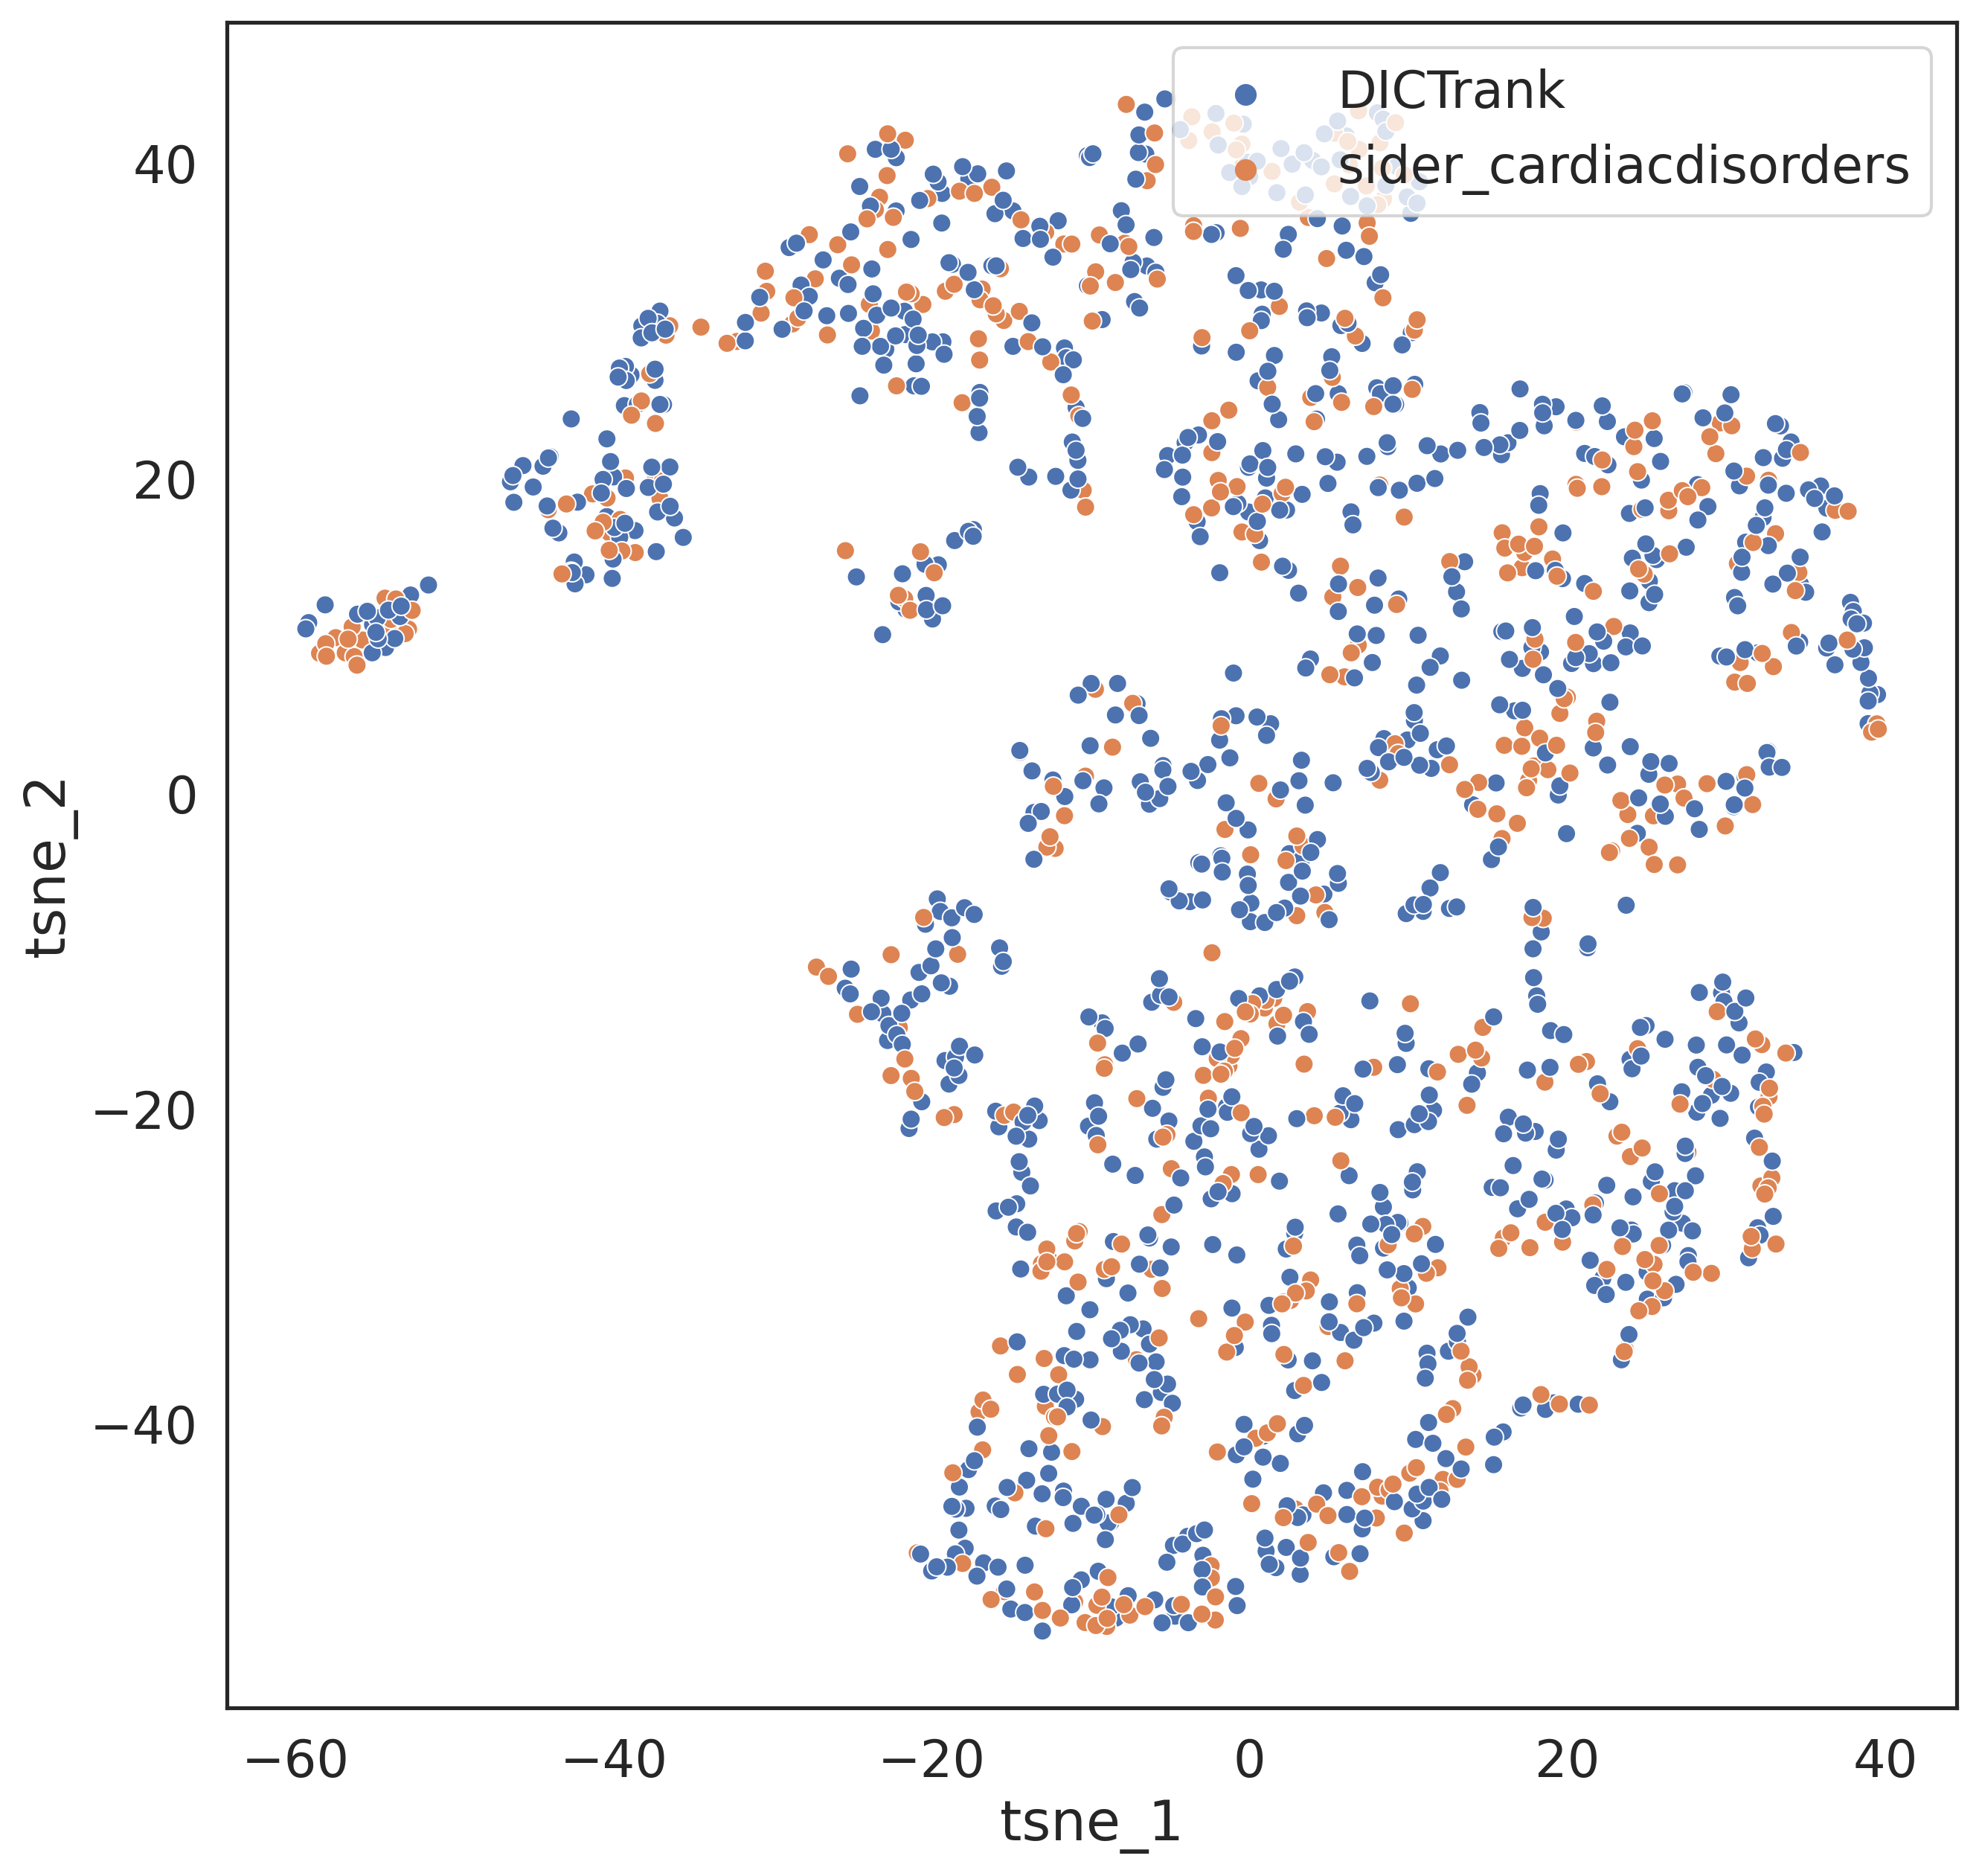

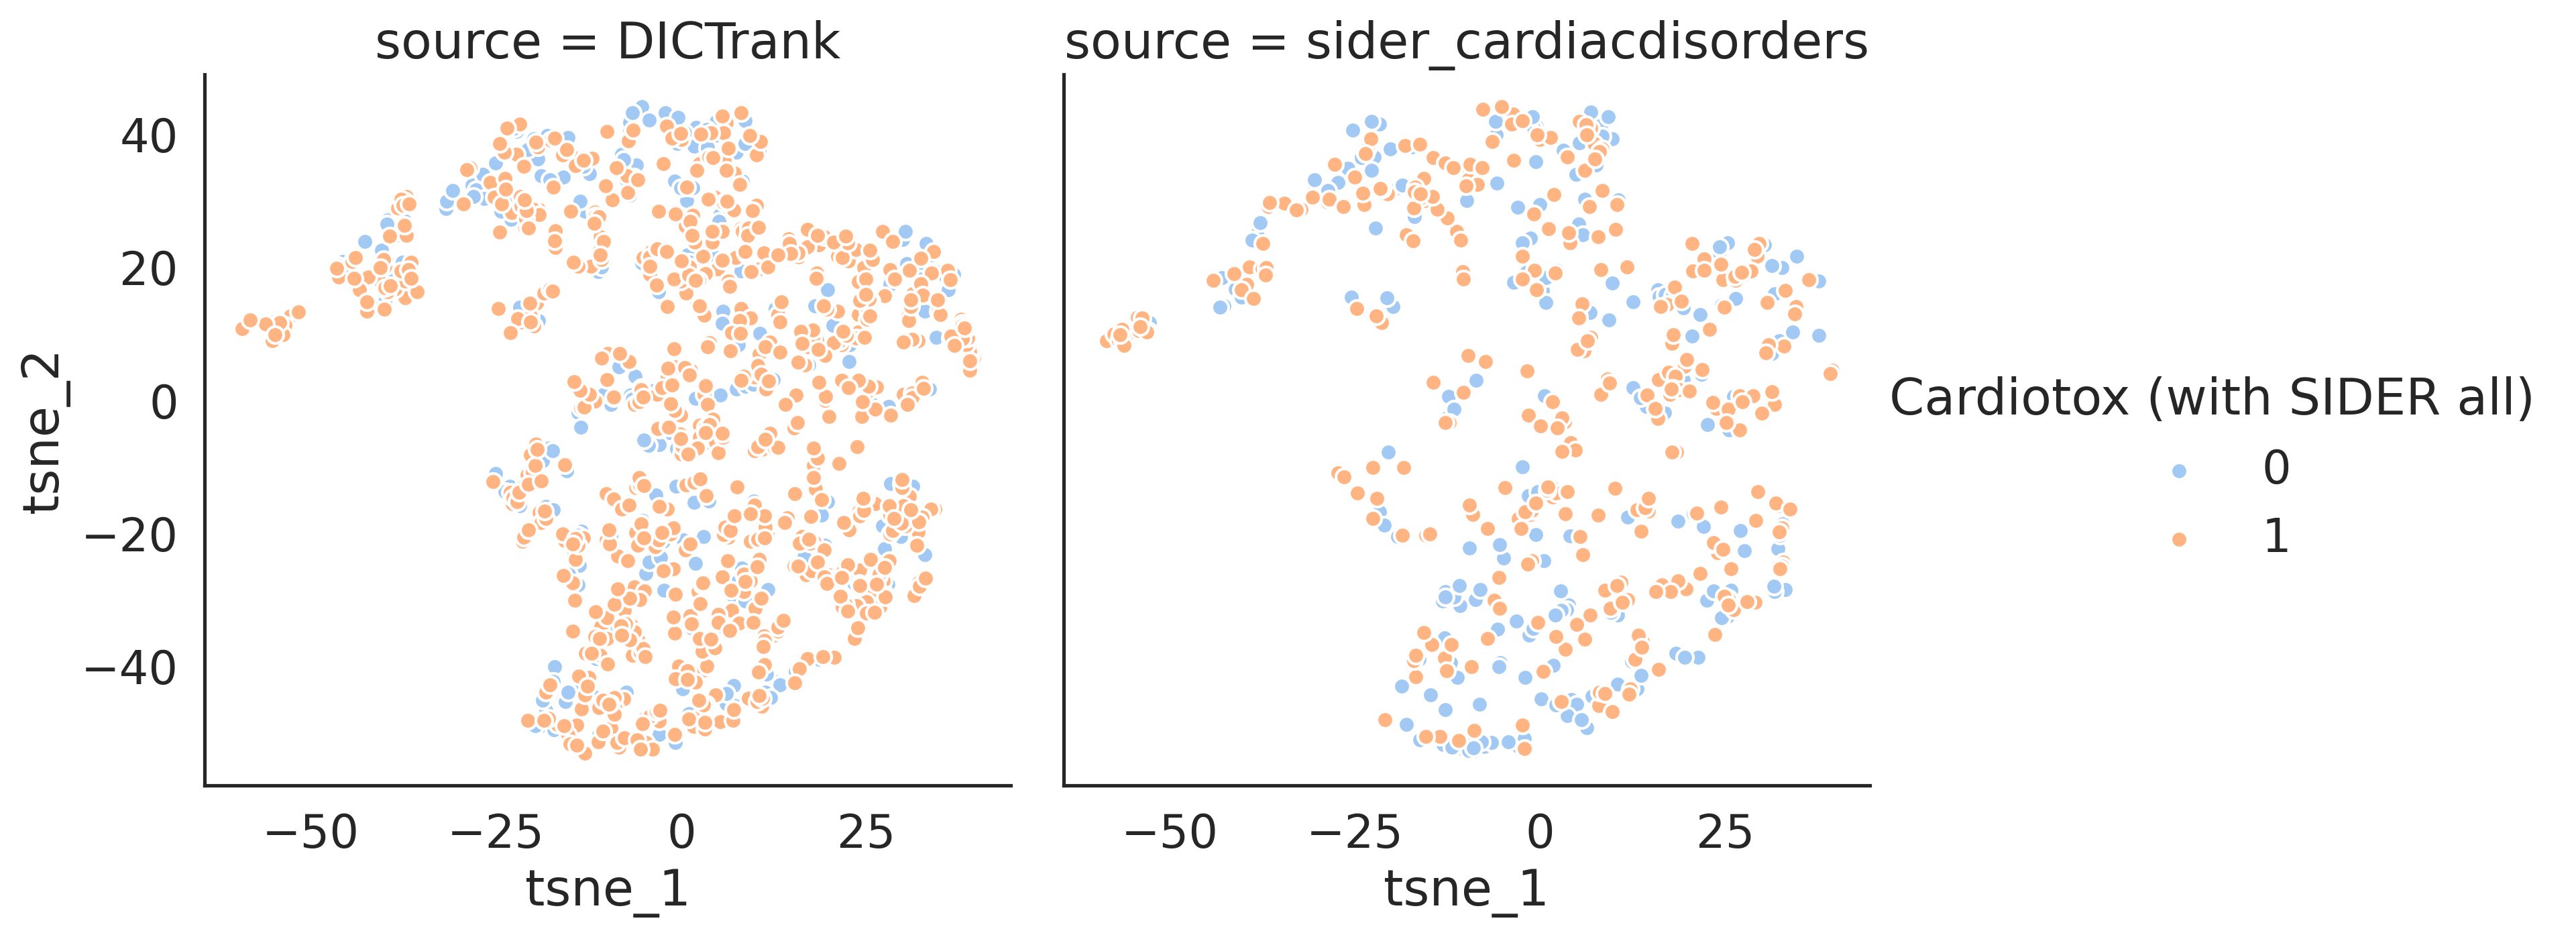

In [85]:
sns.set_theme(style='white', palette='pastel', font_scale=1.5, rc={'figure.dpi': 300})
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
sns.scatterplot(data=df, x="tsne_1", y="tsne_2", hue="source", palette="deep")
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

sns.set_theme(style='white', palette='pastel', font_scale=1.5, rc={'figure.dpi': 300})
graph = sns.FacetGrid(df, col="source", hue="Cardiotox (with SIDER all)", height=5, aspect=1)
graph.map(plt.scatter, "tsne_1", "tsne_2", edgecolor="w").add_legend()
plt.show()

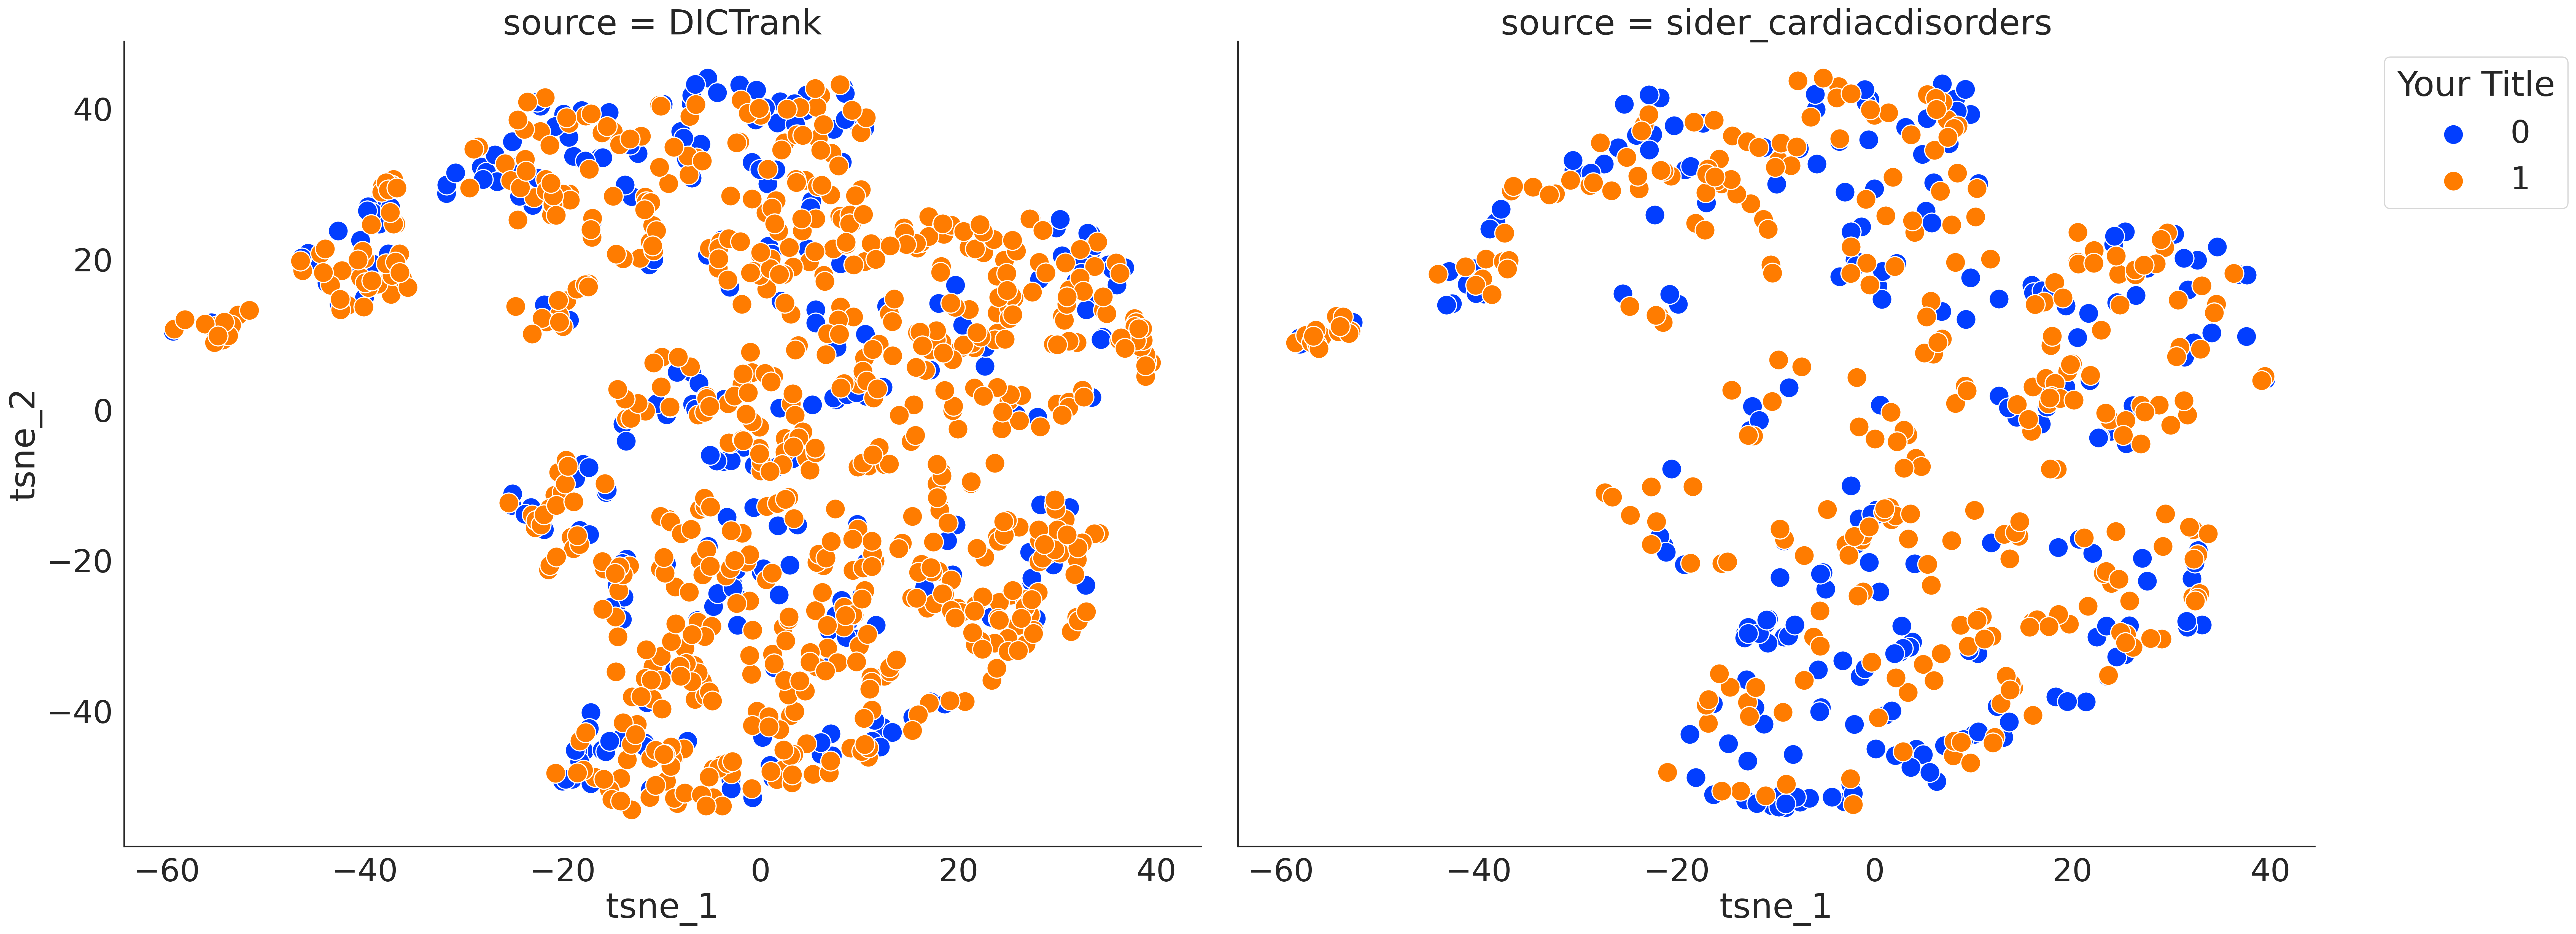

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the theme with a larger font scale and a brighter palette
sns.set_theme(style='white', palette='bright', font_scale=2.5, rc={'figure.dpi': 300})

# Create the FacetGrid with increased height and aspect ratio for larger figures
graph = sns.FacetGrid(df, col="source", hue="Cardiotox (with SIDER all)", height=12, aspect=1.2)
graph.map(plt.scatter, "tsne_1", "tsne_2", edgecolor="w", s=300)  # Increased dot size with `s=100`

# Place the legend outside on the top right of the last plot in the FacetGrid
graph.axes[0][-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Your Title")
plt.show()
